In [23]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# plt.rc('font', family='serif')
# plt.rcParams.update({'font.size': 18})
# plt.grid(linestyle='dotted')
# plt.tight_layout() 

In [24]:
## MITx_6.00x_2012_Fall.csv, HarvardX_ER22x_2013_Spring
def data_prep( course_name, half_chapter):
  df = pd.read_csv(course_name)
  if course_name == "HarvardX_ER22x_2013_Spring.csv":
    df.loc[:,'nplay_video'] = 0.0
  df = df[ df['nchapters'] >= half_chapter ]
  df = df.drop(columns= ['course_id','userid_DI', 'registered', 'incomplete_flag','final_cc_cname_DI'])
  df['start_time_DI'] = pd.to_datetime(df['start_time_DI'])
  df['last_event_DI'] = pd.to_datetime(df['last_event_DI'])
  df['Learning_days'] = (df['last_event_DI'] - df['start_time_DI']).dt.days
  df = df.drop(columns= ['start_time_DI','last_event_DI'])
  df = df.dropna(axis = 1, how ='all')
  df = df.dropna(axis = 0, how ='all')
  df = df.dropna(axis = 0, how = 'any')

  df['YoB'] = df['YoB'].astype('Int64')
  df['Age'] = datetime.now().year - df['YoB']
  df = df.drop(columns= ['YoB'])
  df['grade'].replace(' ', np.nan, inplace=True)
  df = df.dropna(axis=0)
  df['grade'] = pd.to_numeric(df['grade'])
  #print( len(pd.unique(df['final_cc_cname_DI']) ))
  y = df.pop('certified')
  y = y.to_numpy()
  X = pd.get_dummies(df, dtype=float)
  X = X.to_numpy()    # X.shape (2560, 17)
  print(X.shape)
  return X, y


In [25]:
seed = 34
# Training data
X, y =  data_prep('MITx_6.00x_2012_Fall.csv', 9.5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state= seed)

# Shifting data and OOD
X_shift, y_shift =  data_prep('HarvardX_ER22x_2013_Spring.csv', 17)
OOD_1 = pd.read_csv('OOD_1.csv')
OOD_1 = OOD_1.to_numpy()

# Scale all data 
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print(scaler.data_max_)
print(scaler.data_min_)
print(scaler.data_max_ - scaler.data_min_)

X_shift =  scaler.transform(X_shift)
OOD_1 =  scaler.transform(OOD_1)


(2560, 17)
(2868, 17)
[1.000e+00 1.000e+00 1.000e+00 5.318e+04 1.620e+02 8.632e+03 1.800e+01
 6.000e+00 4.050e+02 8.700e+01 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00]
[ 1.  0.  0.  2.  1.  1. 10.  0.  0. 11.  0.  0.  0.  0.  0.  0.  0.]
[0.0000e+00 1.0000e+00 1.0000e+00 5.3178e+04 1.6100e+02 8.6310e+03
 8.0000e+00 6.0000e+00 4.0500e+02 7.6000e+01 1.0000e+00 1.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00]


In [26]:
import tensorflow as tf
import official.nlp.modeling.layers as nlp_layers
tf.autograph.set_verbosity(0)
tf.random.set_seed(12)
tf.keras.utils.set_random_seed(12)
tf.config.experimental.enable_op_determinism()

In [27]:
class DeepResNet(tf.keras.Model):
  """Defines a multi-layer residual network."""
  def __init__(self, num_classes, num_layers=3, num_hidden=128,
               dropout_rate=0.1, **classifier_kwargs):
    
    super().__init__()
    # Defines class meta data.
    self.num_hidden = num_hidden
    self.num_layers = num_layers
    self.dropout_rate = dropout_rate
    self.classifier_kwargs = classifier_kwargs

    # Defines the hidden layers.
    self.input_layer = tf.keras.layers.Dense(self.num_hidden, trainable=False)
    self.dense_layers = [ self.make_dense_layer() for _ in range(num_layers) ]

    # Defines the output layer.
    self.classifier = self.make_output_layer(num_classes)
 
  def call(self, inputs):  # , return_hidden = False
    # Projects the 2d input data to high dimension.
    hidden = self.input_layer(inputs)
    # Computes the ResNet hidden representations.
    for i in range(self.num_layers):
      resid = self.dense_layers[i](hidden)
      resid = tf.keras.layers.Dropout(self.dropout_rate)(resid)
      hidden += resid
    return hidden, self.classifier(hidden)

  def make_dense_layer(self):
    """Uses the Dense layer as the hidden layer."""
    return tf.keras.layers.Dense(self.num_hidden, activation="relu")

  def make_output_layer(self, num_classes):
    """Uses the Dense layer as the output layer."""
    return tf.keras.layers.Dense(
        num_classes, **self.classifier_kwargs)

In [28]:
resnet_config = dict(num_classes = 2, num_layers= 3, num_hidden= 64)
resnet_model = DeepResNet(**resnet_config)
resnet_model.build( (None, 17) )
resnet_model.summary()

Model: "deep_res_net_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             multiple                  1152      
                                                                 
 dense_10 (Dense)            multiple                  4160      
                                                                 
 dense_11 (Dense)            multiple                  4160      
                                                                 
 dense_12 (Dense)            multiple                  4160      
                                                                 
 dense_13 (Dense)            multiple                  130       
                                                                 
Total params: 13762 (53.76 KB)
Trainable params: 12610 (49.26 KB)
Non-trainable params: 1152 (4.50 KB)
_________________________________________________________________


In [29]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.keras.metrics.SparseCategoricalAccuracy()
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-4)

train_config = dict(loss=loss, metrics=metrics, optimizer=optimizer)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 100,
                                            restore_best_weights = True)

In [30]:
fit_config = dict(batch_size = 32, epochs= 1000,
            validation_data = (X_val, y_val), callbacks=[callback] )
resnet_model.compile(**train_config)
history = resnet_model.fit(X_train, y_train, **fit_config)

Epoch 1/1000


2023-12-13 13:25:46.445724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - ETA: 0s - loss: 4.5000 - output_1_loss: 3.7654 - output_2_loss: 0.7346 - output_1_sparse_categorical_accuracy: 0.1671 - output_2_sparse_categorical_accuracy: 0.6462

2023-12-13 13:25:48.382923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - 3s 31ms/step - loss: 4.5000 - output_1_loss: 3.7654 - output_2_loss: 0.7346 - output_1_sparse_categorical_accuracy: 0.1671 - output_2_sparse_categorical_accuracy: 0.6462 - val_loss: 3.6494 - val_output_1_loss: 3.1405 - val_output_2_loss: 0.5088 - val_output_1_sparse_categorical_accuracy: 0.4488 - val_output_2_sparse_categorical_accuracy: 0.7122
Epoch 2/1000
58/58 [==============================] - 1s 22ms/step - loss: 3.2906 - output_1_loss: 2.7757 - output_2_loss: 0.5148 - output_1_sparse_categorical_accuracy: 0.5399 - output_2_sparse_categorical_accuracy: 0.7368 - val_loss: 2.7094 - val_output_1_loss: 2.2957 - val_output_2_loss: 0.4137 - val_output_1_sparse_categorical_accuracy: 0.6341 - val_output_2_sparse_categorical_accuracy: 0.8195
Epoch 3/1000
58/58 [==============================] - 1s 20ms/step - loss: 2.5189 - output_1_loss: 2.0991 - output_2_loss: 0.4198 - output_1_sparse_categorical_accuracy: 0.5849 - output_2_sparse_categorical_accu

<Axes: >

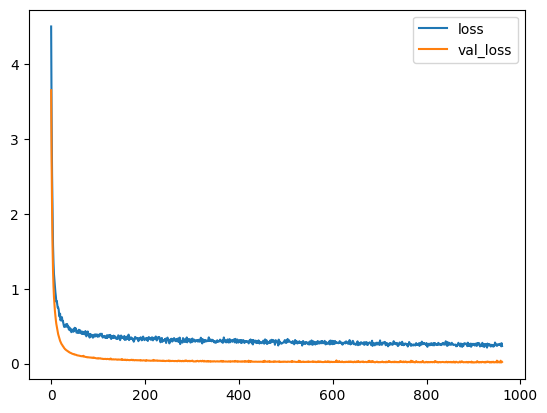

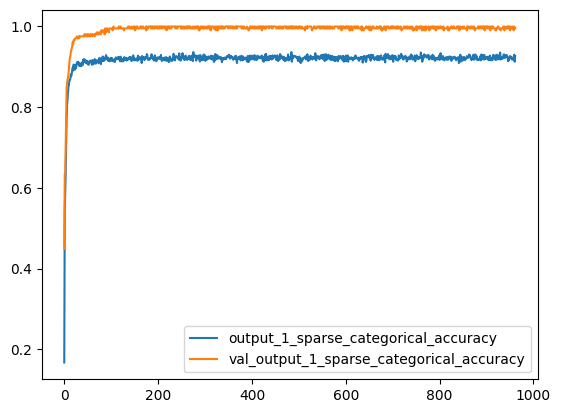

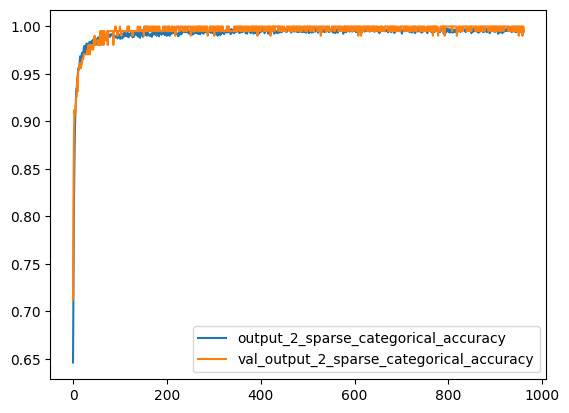

In [31]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss','val_loss']].plot()
history_df.loc[:, ['output_1_sparse_categorical_accuracy','val_output_1_sparse_categorical_accuracy']].plot()
history_df.loc[:, ['output_2_sparse_categorical_accuracy','val_output_2_sparse_categorical_accuracy']].plot()

In [32]:
# Return the training hidden space in Standard NN 
hidden_train_NN, NN_train_logits = resnet_model.predict(X_train)
hidden_shift_NN, NN_shift_logits = resnet_model.predict(X_shift)
hidden_OOD_NN, NN_OOD_logits = resnet_model.predict(OOD_1)

58/58 [==============================] - 0s 3ms/step


2023-12-13 13:45:49.477337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 3ms/step


In [ ]:
# Compute Stanrdard NN accuray 

In [33]:
def NN_accuracy(X, y):
    hidden, logits = resnet_model.predict(X)
    predictions = tf.nn.softmax(logits, axis=-1)[:, 0]
    probs = np.where( predictions > 0.5 , 0, 1)
    accuracy = accuracy_score(y, probs)
    print(f'accuracy -- {accuracy}')
    return accuracy

NN_accuracy_test = NN_accuracy(X_test, y_test)
NN_accuracy_shift = NN_accuracy(X_shift, y_shift)

16/16 [==============================] - 0s 2ms/step
accuracy -- 0.990234375
90/90 [==============================] - 0s 2ms/step
accuracy -- 0.9710599721059973


In [34]:
# Save the model
# import keras 
# resnet_model.save('Standard_model',save_format='tf')

# # Recreate the exact same model purely from the file
# resnet_model = keras.models.load_model('Standard_model')

In [35]:
# resnet_model = tf.keras.models.load_model('resnet_model.h5')
# #resnet_model = tf.keras.models.load_model('resnet_model.keras')

In [36]:
# SNGP 

In [37]:
class DeepResNetSNGP(DeepResNet):
  def __init__( self, spec_norm_bound = 0.9, **kwargs ):
    self.spec_norm_bound = spec_norm_bound
    super().__init__(**kwargs)

  # Override the father class's method
  def make_dense_layer(self):
    """Applies spectral normalization to the hidden layer."""
    dense_layer = super().make_dense_layer()
    return nlp_layers.SpectralNormalization(
        dense_layer, norm_multiplier = self.spec_norm_bound)

  # Override the father class's method
  def make_output_layer(self, num_classes):
    """Uses Gaussian process as the output layer."""
    return nlp_layers.RandomFeatureGaussianProcess(
        num_classes,
        gp_kernel_scale = 10.0,
        gp_cov_momentum = -1,
        **self.classifier_kwargs)
  
  def call(self, inputs, training=False, return_covmat=False): #, return_hidden=True
    # Gets logits and a covariance matrix from the GP layer.
    # super().cal() -- call the parents' call()
    hidden, (logits, covmat) = super().call(inputs) #, return_hidden=True
    # print("logits", logits.shape)
    # print("covmat", covmat)

    # Returns only logits during training.
    if not training and return_covmat : # and return_hidden
      return hidden, logits, covmat

    return logits

In [38]:
class ResetCovarianceCallback(tf.keras.callbacks.Callback):
  def on_epoch_begin(self, epoch, logs = None):
    """Resets covariance matrix at the beginning of the epoch."""
    if epoch > 0:
      self.model.classifier.reset_covariance_matrix()

In [39]:
class DeepResNetSNGPWithCovReset(DeepResNetSNGP):
  def fit(self, *args, **kwargs):
    """Adds ResetCovarianceCallback to model callbacks."""
    kwargs["callbacks"] = list(kwargs.get("callbacks", []))
    kwargs["callbacks"].append(ResetCovarianceCallback())
    return super().fit(*args, **kwargs)

In [40]:
# This mean-field method is implemented as a built-in function layers.gaussian_process.mean_field_logits:
def compute_posterior_mean_probability(logits, covmat, lambda_param=np.pi / 8.):
  logits_adjusted = nlp_layers.gaussian_process.mean_field_logits(
      logits, covmat, mean_field_factor=lambda_param)
  return tf.nn.softmax(logits_adjusted, axis=-1)[:,0]

In [41]:
sngp_model = DeepResNetSNGPWithCovReset(**resnet_config)
sngp_model.compile(**train_config)
history = sngp_model.fit(X_train, y_train, **fit_config)

Epoch 1/1000


2023-12-13 13:45:51.264048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - ETA: 0s - loss: 0.5777 - sparse_categorical_accuracy: 0.7260

2023-12-13 13:45:53.649365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - 3s 37ms/step - loss: 0.5777 - sparse_categorical_accuracy: 0.7260 - val_loss: 0.4505 - val_sparse_categorical_accuracy: 0.9171
Epoch 2/1000
58/58 [==============================] - 2s 29ms/step - loss: 0.3848 - sparse_categorical_accuracy: 0.9387 - val_loss: 0.3191 - val_sparse_categorical_accuracy: 0.9415
Epoch 3/1000
58/58 [==============================] - 2s 29ms/step - loss: 0.2930 - sparse_categorical_accuracy: 0.9604 - val_loss: 0.2589 - val_sparse_categorical_accuracy: 0.9561
Epoch 4/1000
58/58 [==============================] - 2s 29ms/step - loss: 0.2412 - sparse_categorical_accuracy: 0.9664 - val_loss: 0.2205 - val_sparse_categorical_accuracy: 0.9610
Epoch 5/1000
58/58 [==============================] - 2s 29ms/step - loss: 0.2094 - sparse_categorical_accuracy: 0.9685 - val_loss: 0.1962 - val_sparse_categorical_accuracy: 0.9610
Epoch 6/1000
58/58 [==============================] - 2s 28ms/step - loss: 0.1871 - sparse_categorical_accur

<Axes: >

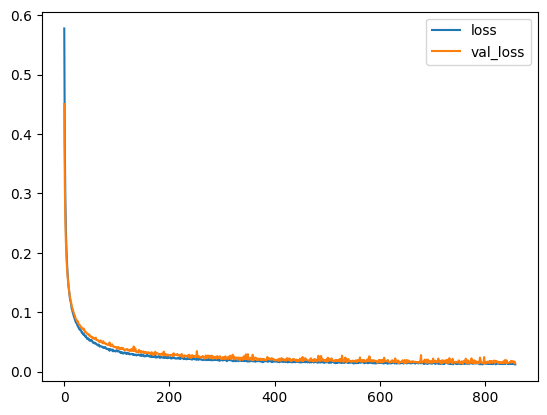

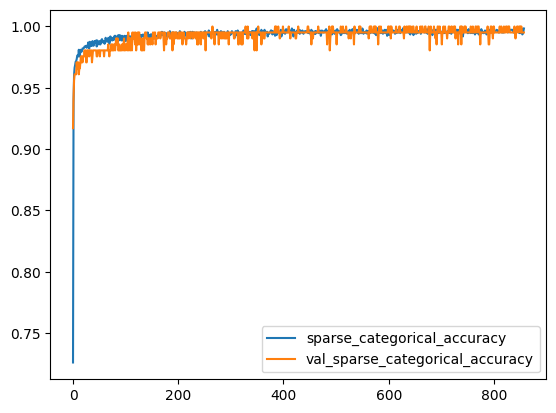

In [42]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss','val_loss']].plot()
history_df.loc[:, ['sparse_categorical_accuracy','val_sparse_categorical_accuracy']].plot()

In [43]:
# resnet_model.save('SNGP_model',save_format='tf')
# # Recreate the exact same model purely from the file
# resnet_model = keras.models.load_model('SNGP_model')

In [44]:
def compute_variance(x):
  hidden, sngp_logits, sngp_covmat = sngp_model(x, return_covmat=True)
  sngp_variance = tf.linalg.diag_part(sngp_covmat)[:, None]
  mean_var = np.mean(sngp_variance)
  print(f'Mean variance -- {mean_var}')
  return hidden, sngp_variance

train_hidden_sngp, train_var_sngp = compute_variance(X_train)

test_hidden_sngp, test_var_sngp = compute_variance(X_test)
shift_hidden_sngp, shift_var_sngp = compute_variance(X_shift)
OOD_hidden_sngp, OOD_var_sngp = compute_variance(OOD_1)

#train_var_sngp = train_var_sngp.numpy().ravel()
test_var_sngp = test_var_sngp.numpy().ravel()
shift_var_sngp = shift_var_sngp.numpy().ravel()
OOD_var_sngp = OOD_var_sngp.numpy().ravel()

Mean variance -- 0.027822282165288925
Mean variance -- 0.026653166860342026
Mean variance -- 0.17605507373809814
Mean variance -- 0.3761860132217407


In [45]:
def compute_accuracy(model, X, y):
  hidden, sngp_logits, sngp_covmat = model(X, return_covmat=True)
  sngp_probs = compute_posterior_mean_probability(sngp_logits, sngp_covmat)
  probs = np.where( sngp_probs > 0.5 , 0, 1)
  accuracy = accuracy_score(y, probs)
  print(f'SNGP accuracy --{accuracy}')
  return
compute_accuracy(sngp_model, X_test, y_test)
compute_accuracy(sngp_model, X_shift, y_shift)

SNGP accuracy --0.98828125
SNGP accuracy --0.9599023709902371


In [46]:
# Compute input distance 

In [47]:
def compute_distane(train_hidden, test_hidden, k = 10):
    distances = tf.norm(tf.expand_dims(test_hidden, axis=1) - tf.expand_dims(train_hidden, axis=0), axis=-1)
    topk_distances, topk_indices = tf.math.top_k(-distances, k=k)  # Use negative distances for smallest k distances
    return - topk_distances

In [48]:
test_distance = compute_distane(X_train, X_test)
shift_distance = compute_distane(X_train, X_shift)
OOD_distance = compute_distane(X_train, OOD_1)

# Compute mean along axis = 1 (rows)
test_mean_inp = tf.reduce_mean(test_distance, axis=1).numpy()
shift_mean_inp = tf.reduce_mean(shift_distance, axis=1).numpy()
OOD_mean_inp = tf.reduce_mean(OOD_distance, axis=1).numpy()

In [49]:
# Hidden distance space in SNGP

In [50]:
test_distance_sngp = compute_distane(train_hidden_sngp, test_hidden_sngp)
shift_distance_sngp = compute_distane(train_hidden_sngp, shift_hidden_sngp)
OOD_distance_sngp = compute_distane(train_hidden_sngp, OOD_hidden_sngp)

# Compute mean along axis 1 (rows)
test_mean_sngp = tf.reduce_mean(test_distance_sngp, axis=1).numpy()
shift_mean_sngp = tf.reduce_mean(shift_distance_sngp, axis=1).numpy()
OOD_mean_sngp = tf.reduce_mean(OOD_distance_sngp, axis=1).numpy()

In [51]:
# MC Dropout

In [52]:
num_ensemble = 10

In [53]:
def mc_dropout_sampling(test_examples):
  # Enable dropout during inference.
  hidden, logits = resnet_model(test_examples, training=True)
  return hidden, logits

In [54]:
# Monte Carlo dropout inference.
def Compute_MC(model, X, y):
  hidden = model(X)[0]
  dropout_logit_samples = [model(X)[1] for _ in range(num_ensemble)]

  dropout_prob_samples = [ tf.nn.softmax(dropout_logits, axis=-1)[:, 0] for dropout_logits in dropout_logit_samples]
  vars = np.var(dropout_prob_samples, axis=0)

  dropout_probs = tf.reduce_mean(dropout_prob_samples, axis=0)
  probs = np.where( dropout_probs > 0.5 , 0, 1)
  accuracy = accuracy_score(y, probs)

  #uncertainty = (dropout_probs)*(1-dropout_probs)
  print(f'Accuracy: {accuracy} -- Mean variance:{np.mean(vars)}')
  return hidden, vars

train_hidden_mc, var_mc = Compute_MC(mc_dropout_sampling, X_train, y_train)

test_hidden_mc, test_var_mc = Compute_MC(mc_dropout_sampling, X_test, y_test)
shift_hidden_mc, shift_var_mc = Compute_MC(mc_dropout_sampling, X_shift, y_shift)

Accuracy: 0.9587628865979382 -- Mean variance:0.01239055022597313
Accuracy: 0.943359375 -- Mean variance:0.01525833085179329
Accuracy: 0.9633891213389121 -- Mean variance:0.026850270107388496


In [55]:
# OOD
def Compute_MC_OOD(model, X):
  hidden = model(X)[0]
  dropout_logit_samples = [model(X)[1] for _ in range(num_ensemble)]
  dropout_prob_samples = [ tf.nn.softmax(dropout_logits, axis=-1)[:, 0] for dropout_logits in dropout_logit_samples]
  vars = np.var(dropout_prob_samples, axis=0)
  print(f'Mean Variance --{np.mean(vars)}')
  print(hidden.shape)
  return hidden, vars
OOD_hidden_mc, OOD_var_mc = Compute_MC_OOD(mc_dropout_sampling, OOD_1)

Mean Variance --0.0060769617557525635
(559, 64)


In [56]:
test_distance_mc = compute_distane(train_hidden_mc, test_hidden_mc)
shift_distance_mc = compute_distane(train_hidden_mc, shift_hidden_mc)
OOD_distance_mc = compute_distane(train_hidden_mc, OOD_hidden_mc)

# compute mean along axis 1 (rows)
test_mean_mc = tf.reduce_mean(test_distance_mc, axis=1).numpy()
shift_mean_mc = tf.reduce_mean(shift_distance_mc, axis=1).numpy()
OOD_mean_mc = tf.reduce_mean(OOD_distance_mc, axis=1).numpy()

In [57]:
# plot_hidden_distance_hist(test_mean_mc , shift_mean_mc, OOD_mean_mc, 'Hidden_Dist_Hist_mc.pdf' )
# scatter_var_dist(test_mean_mc, shift_mean_mc, OOD_mean_mc, test_var_mc, shift_var_mc, OOD_var_mc, 'Dist_Var_MC.pdf')
# plot_variance_hist(test_var_mc, shift_var_mc, OOD_var_mc, 'MC_Var.pdf') # np.finfo(float).eps

In [58]:
# Deep ensemble training

In [59]:
resnet_ensemble = []
for _ in range(num_ensemble):
  resnet_model = DeepResNet(**resnet_config)
  resnet_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
  resnet_model.fit(X_train, y_train, verbose=0, **fit_config)

  resnet_ensemble.append(resnet_model)

2023-12-13 14:18:57.454004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-13 14:18:59.309369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-13 14:35:50.197185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-13 14:35:52.354912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-13 14:53:15.747394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-13 14:53:17.851491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-13 15:10:14.266866: I tensorflow/core/grappler/optimizers/cust

In [60]:
def Compute_Deep(model_list, X, y):

  hidden = [model(X)[0] for model in model_list]

  hidden = tf.reduce_mean(hidden, axis = 0)

  ensemble_logit_samples = [model(X)[1] for model in model_list]
  ensemble_prob_samples = [tf.nn.softmax(logits, axis=-1)[:, 0] for logits in ensemble_logit_samples]
  ensemble_probs = tf.reduce_mean(ensemble_prob_samples, axis=0)

  vars = np.var(ensemble_prob_samples, axis = 0)
  probs = np.where( ensemble_probs > 0.5 , 0, 1)
  
  accuracy = accuracy_score(y, probs)

  #uncertainty = ensemble_probs * (1 - ensemble_probs)
  #uncertainty = np.mean(uncertainty)
  print(f'accuracy: {accuracy} -- Mean Variance:{np.mean(vars)}')
  return hidden, vars

train_hidden_deep, var = Compute_Deep(resnet_ensemble, X_train, y_train)

test_hidden_deep, test_var_deep = Compute_Deep(resnet_ensemble, X_test, y_test)
shift_hidden_deep, shift_var_deep = Compute_Deep(resnet_ensemble, X_shift, y_shift)

accuracy: 0.9734129137276181 -- Mean Variance:0.03572468459606171
accuracy: 0.943359375 -- Mean Variance:0.04557089880108833
accuracy: 0.9232914923291492 -- Mean Variance:0.08886536955833435


In [61]:
def Compute_Deep_OOD(model_list, X):
  hidden = [ model(X)[0] for model in model_list]
  hidden = tf.reduce_mean(hidden, axis = 0)

  ensemble_logit_samples = [model(X)[1] for model in model_list]
  #print(ensemble_logit_samples)
  
  predictions = [tf.nn.softmax(logits)[:,0] for logits in ensemble_logit_samples]
  #print(ensemble_prob_samples)
  vars = np.var(predictions, axis = 0)
  print(f'Mean Variance--{np.mean(vars)}')

  return hidden, vars

OOD_hidden_deep, OOD_var_deep = Compute_Deep_OOD(resnet_ensemble, OOD_1)

Mean Variance--0.14900736510753632


In [62]:
test_distance_deep = compute_distane(train_hidden_deep, test_hidden_deep)
shift_distance_deep = compute_distane(train_hidden_deep, shift_hidden_deep)
OOD_distance_deep = compute_distane(train_hidden_deep, OOD_hidden_deep)

# compute mean along axis 1 (rows)
test_mean_deep = tf.reduce_mean(test_distance_deep, axis=1).numpy()
shift_mean_deep = tf.reduce_mean(shift_distance_deep, axis=1).numpy()
OOD_mean_deep = tf.reduce_mean(OOD_distance_deep, axis=1).numpy()

In [63]:
print(OOD_mean_deep.shape)
print(OOD_var_deep.shape)

(559,)
(559,)


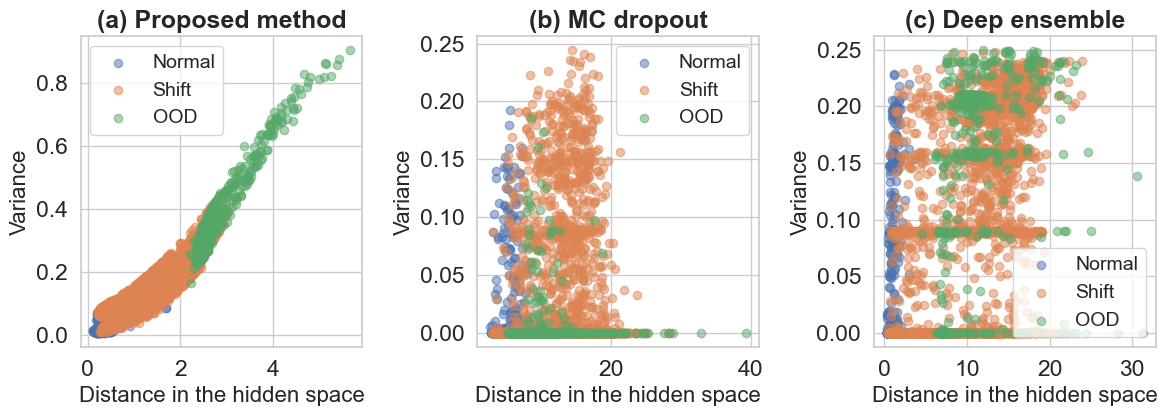

In [69]:
sns.set(style="whitegrid", font_scale = 1.5 )

fig, (ax1, ax2, ax3) = plt.subplots( 1, 3, figsize=(12, 4.5), tight_layout=True ) # 11.69,8.27

ax1.scatter(test_mean_sngp,  test_var_sngp,  alpha= 0.5, rasterized=True,  label = 'Normal') #color = 'blue',color = 'orange',color = 'green',  
ax1.scatter(shift_mean_sngp, shift_var_sngp, alpha= 0.5, rasterized=True,label = 'Shift')
ax1.scatter(OOD_mean_sngp,   OOD_var_sngp,   alpha= 0.5, rasterized=True,label = 'OOD')


ax1.legend(fontsize=14)
ax1.set_xlabel('Distance in the hidden space', fontsize = 16)
ax1.set_ylabel('Variance', fontsize = 16)
ax1.set_title('(a) Proposed method', fontweight="bold")


ax2.scatter(test_mean_mc,  test_var_mc,  alpha= 0.5,  rasterized=True, label = 'Normal') #color = 'blue',color = 'orange',color = 'green',  
ax2.scatter(shift_mean_mc, shift_var_mc, alpha= 0.5, rasterized=True, label = 'Shift')
ax2.scatter(OOD_mean_mc,   OOD_var_mc,   alpha= 0.5, rasterized=True, label = 'OOD')

ax2.legend(fontsize=14)
ax2.set_xlabel('Distance in the hidden space', fontsize = 16)
ax2.set_ylabel('Variance', fontsize = 16)
ax2.set_title('(b) MC dropout', fontweight="bold")


ax3.scatter(test_mean_deep,  test_var_deep,  alpha= 0.5, rasterized=True,  label = 'Normal') #color = 'blue',color = 'orange',color = 'green',  
ax3.scatter(shift_mean_deep, shift_var_deep, alpha= 0.5, rasterized=True,label = 'Shift')
ax3.scatter(OOD_mean_deep,   OOD_var_deep,   alpha= 0.5, rasterized=True, label = 'OOD')
ax3.legend(fontsize=14)
ax3.set_xlabel('Distance in the hidden space', fontsize = 16)
ax3.set_ylabel('Variance', fontsize = 16)
ax3.set_title('(c) Deep ensemble', fontweight="bold")

plt.tight_layout() 
plt.savefig('Dist-Var-comb.pdf')
plt.show()

In [72]:
def cal_correlation(x1, x2):
    correlation_matrix = np.corrcoef(x1, x2)
    correlation_coefficient = correlation_matrix[0, 1]
    return correlation_coefficient

def concat_data(x1, x2, x3):
    return np.concatenate((x1, x2, x3), axis = 0)

sngp_dist = concat_data(test_mean_sngp,shift_mean_sngp,OOD_mean_sngp)
sngp_var =  concat_data(test_var_sngp, shift_var_sngp, OOD_var_sngp)
print(cal_correlation(sngp_dist, sngp_var))

print(cal_correlation(test_mean_sngp,  test_var_sngp))
print(cal_correlation(shift_mean_sngp, shift_var_sngp))
print(cal_correlation(OOD_mean_sngp,   OOD_var_sngp))


mc_dist = concat_data(test_mean_mc, shift_mean_mc, OOD_mean_mc)
mc_var =  concat_data(test_var_mc, shift_var_mc, OOD_var_mc)
print(cal_correlation(mc_dist, mc_var))
print(cal_correlation(test_mean_mc,  test_var_mc))
print(cal_correlation(shift_mean_mc, shift_var_mc))
print(cal_correlation(OOD_mean_mc,   OOD_var_mc))


deep_dist = concat_data(test_mean_deep, shift_mean_deep, OOD_mean_deep)
deep_var =  concat_data(test_var_deep.ravel(), shift_var_deep.ravel(), OOD_var_deep.ravel())
print(cal_correlation(deep_dist, deep_var))
print(cal_correlation(test_mean_deep,  test_var_deep))
print(cal_correlation(shift_mean_deep, shift_var_deep))
print(cal_correlation(OOD_mean_deep,   OOD_var_deep))

0.9281121350721501
0.41003335774673494
0.8941343978229932
0.9643170800808429
0.20742625324859357
-0.021120476081305038
0.21608931816601096
0.02052302874764377
0.531144344106872
0.41902546423438386
0.565997234262693
0.26380191881552456


/var/folders/2r/f_yg3mks3kz3wj78zfzh45zr0000gn/T/ipykernel_2294/3184312117.py:45: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


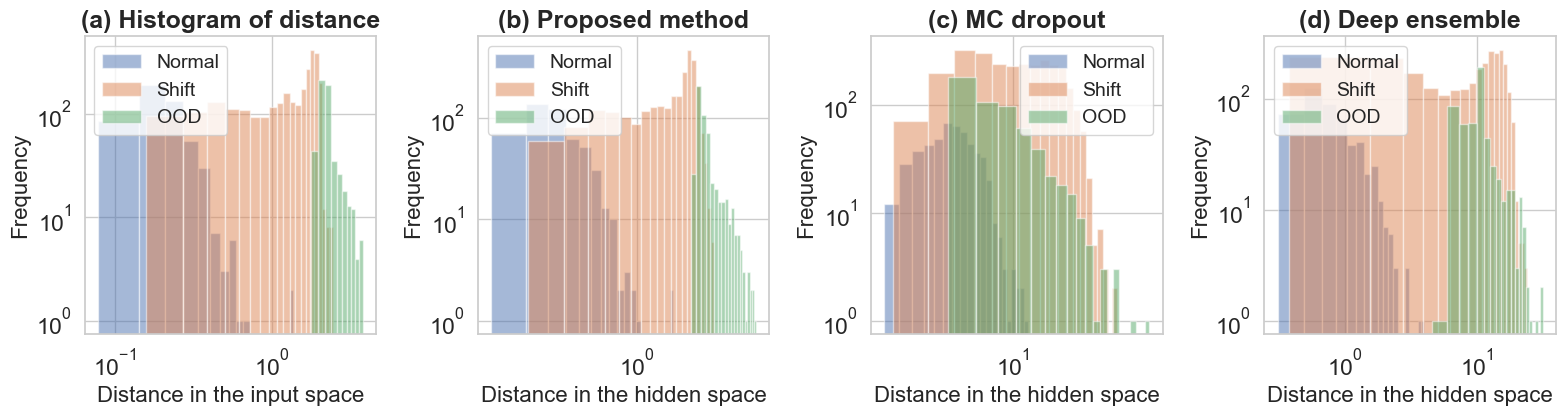

In [66]:
sns.set(style="whitegrid", font_scale = 1.5)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 4.5), layout='constrained' ) # 11.69,8.27

ax1.hist(test_mean_inp, bins = 20, alpha= 0.5, label = 'Normal') # density=True,
ax1.hist(shift_mean_inp, bins = 20, alpha= 0.5, label = 'Shift')
ax1.hist(OOD_mean_inp, alpha= 0.5, label = 'OOD')
ax1.set_xscale('log', base=10)
ax1.set_yscale('log', base=10)
ax1.legend(fontsize=14)
ax1.set_xlabel('Distance in the input space', fontsize = 16)
ax1.set_ylabel('Frequency', fontsize = 16)
ax1.set_title('(a) Histogram of distance', fontweight="bold")


ax2.set_xscale('log', base=10)
ax2.set_yscale('log', base=10)
ax2.hist(test_mean_sngp,  bins = 20, alpha= 0.5,  label = 'Normal') #color = 'blue',color = 'orange',color = 'green',
ax2.hist(shift_mean_sngp, bins = 20, alpha= 0.5, label = 'Shift')
ax2.hist(OOD_mean_sngp,   bins = 20, alpha= 0.5,  label = 'OOD')
ax2.legend(fontsize=14)
ax2.set_xlabel('Distance in the hidden space', fontsize = 16)
ax2.set_ylabel('Frequency', fontsize = 16)
ax2.set_title('(b) Proposed method', fontweight="bold")

ax3.set_xscale('log', base=10)
ax3.set_yscale('log', base=10)
ax3.hist(test_mean_mc,  bins = 20, alpha= 0.5,  label = 'Normal') #color = 'blue',color = 'orange',color = 'green',
ax3.hist(shift_mean_mc, bins = 20, alpha= 0.5, label = 'Shift')
ax3.hist(OOD_mean_mc,   bins = 20, alpha= 0.5,  label = 'OOD')
ax3.legend(fontsize=14)
ax3.set_xlabel('Distance in the hidden space', fontsize = 16)
ax3.set_ylabel('Frequency', fontsize = 16)
ax3.set_title('(c) MC dropout', fontweight="bold")

ax4.set_xscale('log', base=10)
ax4.set_yscale('log', base=10)
ax4.hist(test_mean_deep,  bins = 20, alpha= 0.5,  label = 'Normal') #color = 'blue',color = 'orange',color = 'green',
ax4.hist(shift_mean_deep, bins = 20, alpha= 0.5,  label = 'Shift')
ax4.hist(OOD_mean_deep,   bins = 20, alpha= 0.5, label = 'OOD')
ax4.legend(fontsize=14)
ax4.set_xlabel('Distance in the hidden space', fontsize = 16)
ax4.set_ylabel('Frequency', fontsize = 16)
ax4.set_title('(d) Deep ensemble', fontweight="bold")

plt.tight_layout()
plt.savefig('Hidden-Distance-comb.pdf')
plt.show()

/var/folders/2r/f_yg3mks3kz3wj78zfzh45zr0000gn/T/ipykernel_2294/2377975689.py:34: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


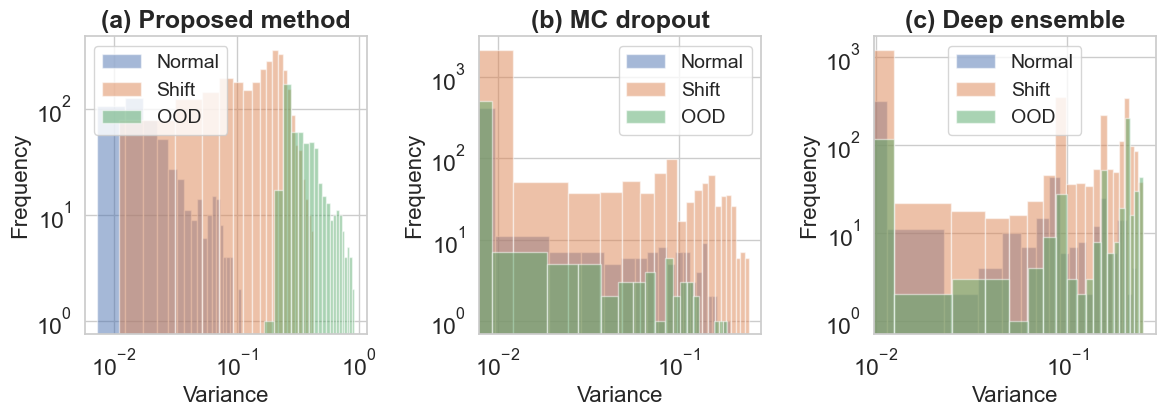

In [67]:
sns.set(style="whitegrid", font_scale = 1.5)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4.5), layout='constrained' )

ax1.hist(test_var_sngp,  bins = 20, alpha= 0.5, label = 'Normal') 
ax1.hist(shift_var_sngp, bins = 20, alpha= 0.5, label = 'Shift')
ax1.hist(OOD_var_sngp,   bins = 20, alpha= 0.5,  label = 'OOD')

ax1.set_xscale('log', base=10)
ax1.set_yscale('log', base=10)
ax1.legend(fontsize=14)
ax1.set_xlabel('Variance', fontsize = 16)
ax1.set_ylabel('Frequency', fontsize = 16)
ax1.set_title('(a) Proposed method', fontweight="bold")

ax2.hist(test_var_mc,  bins = 20, alpha= 0.5,  label = 'Normal') 
ax2.hist(shift_var_mc, bins = 20, alpha= 0.5,  label = 'Shift')
ax2.hist(OOD_var_mc,   bins = 20, alpha= 0.5,  label = 'OOD')
ax2.set_xscale('log', base=10)
ax2.set_yscale('log', base=10)
ax2.legend(fontsize=14)
ax2.set_xlabel('Variance', fontsize = 16)
ax2.set_ylabel('Frequency', fontsize = 16)
ax2.set_title('(b) MC dropout', fontweight="bold")

ax3.hist(test_var_deep,  bins = 20, alpha= 0.5, label = 'Normal') 
ax3.hist(shift_var_deep, bins = 20, alpha= 0.5,  label = 'Shift')
ax3.hist(OOD_var_deep,   bins = 20, alpha= 0.5,  label = 'OOD')
ax3.set_xscale('log', base=10)
ax3.set_yscale('log', base=10)
ax3.legend(fontsize=14)
ax3.set_xlabel('Variance', fontsize = 16)
ax3.set_ylabel('Frequency', fontsize = 16)
ax3.set_title('(c) Deep ensemble', fontweight="bold")
plt.tight_layout()
plt.savefig('Var-hist-comb.pdf')
plt.show()

0.10772248
0.16612208


/var/folders/2r/f_yg3mks3kz3wj78zfzh45zr0000gn/T/ipykernel_2294/1448430330.py:18: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


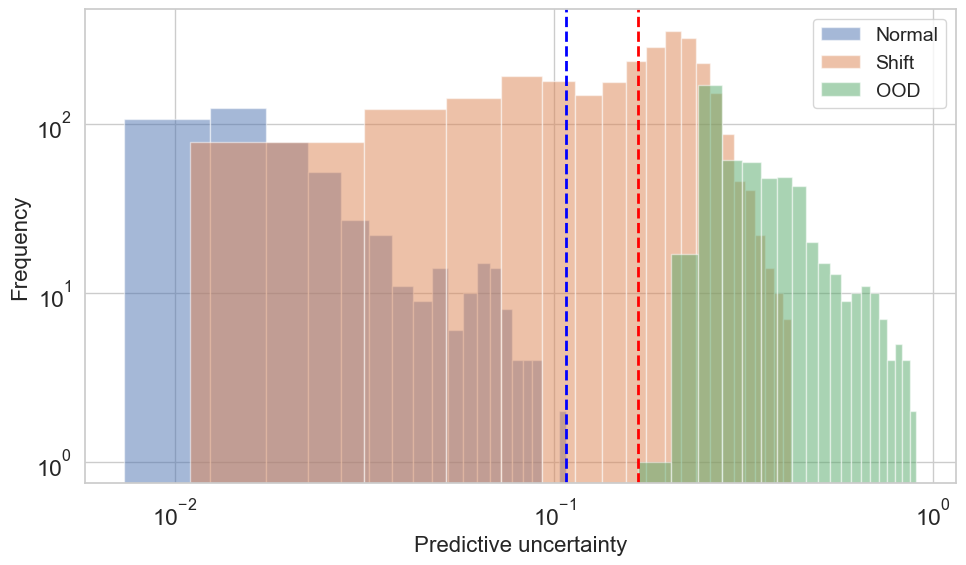

In [70]:
sns.set(style="whitegrid", font_scale = 1.5)
fig, (ax1) = plt.subplots(1,1, figsize=(10, 6), layout='constrained' )

ax1.hist(test_var_sngp,  bins = 20, alpha= 0.5,  label = 'Normal') 
plt.axvline(x= test_var_sngp.max(), color = 'blue', lw = 2, ls = '--' )
print(test_var_sngp.max())
ax1.hist(shift_var_sngp, bins = 20, alpha= 0.5,  label = 'Shift')
plt.axvline(x= OOD_var_sngp.min(), color = 'red', lw = 2, ls = '--')
print(OOD_var_sngp.min())
ax1.hist(OOD_var_sngp,   bins = 20, alpha= 0.5,  label = 'OOD')

ax1.set_xscale('log', base=10)
ax1.set_yscale('log', base=10)
ax1.legend(fontsize=14)
ax1.set_xlabel('Predictive uncertainty', fontsize = 16)
ax1.set_ylabel('Frequency', fontsize = 16)
# ax1.set_title('Proposed method', fontweight="bold")
plt.tight_layout()
plt.savefig('var_risk.pdf')